In [2]:
import sys
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import osr
from osgeo.gdalconst import *
import rasterio
#from rasterio.plot import show
driver = gdal.GetDriverByName('GTiff')
driver.Register()





2

In [3]:
coords_system = osr.SpatialReference()
coords_system.ImportFromEPSG(26915)

def createRaster(filename, array, resol):
    rows, cols = array.shape
    pixelWidth, pixelHeight = resol, resol
    rasterOrigin = (10,10)
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    
    ds = driver.Create(filename, cols, rows, 1, GDT_Float32)
    ds.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    band = ds.GetRasterBand(1)
    band.WriteArray(array)
    band.FlushCache()
    band.SetNoDataValue(-9999)
    ds.SetProjection(coords_system.ExportToWkt())
    
    ds = None

def checkCreatedRaster(dem):
    ds = gdal.Open(dem, GA_ReadOnly)
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    band = ds.GetRasterBand(1)
    elev = band.ReadAsArray(0, 0, cols, rows)
    value = elev[0, 2] 
    print(value)
    
dem = "simple_dem_1x3.tif"
elev = np.array([[203.0, 202.0, 201.0]])
resol = 10
createRaster(dem, elev, resol)
checkCreatedRaster(dem)





#junk
def plotRaster():
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(np.digitize(elev, [201,202,203]))
    plt.show()
    print("\n\n\n")
    #outData = numpy.zeros((rows,cols), numpy.int16)

    raster_plot = rasterio.open(raster)
    rasterio.plot.show(raster_plot, cmap='Reds')


201.0


In [138]:
def runDrainTheAquifer(elevationValues, waterStorageValues, wTableHeightValues, slope,
                       D, fi, Sy, Ks, m, psi_b, n_days, deltaT=1, decaying_transmissivity=True):
    '''
    elevationValues: array of elevation values of cells, i.e. DEM values
    waterStorageValues: array of volumetric water content of cells, in saturated conditions
    wTableHeightValues: array
    etc
    '''

    rows, cols = elevationValues.shape 
    n_steps = 24 * n_days
    Qdict = {}
    Sdict = {}
    Edict = {}
    ddict = {}
    runoffVol = 0
    outlet = [0,2]

    current_time = 0
    print("current time step: {}".format(current_time))
    Qdict[current_time] = np.zeros((rows, cols))
    Sdict[current_time] = waterStorageValues
    Edict[current_time] = elevationValues
    ddict[current_time] = wTableHeightValues
    print("water table height (d) is : {}".format(ddict[current_time]))
    print("water elevation is : {} m asl".format(Edict[current_time]))
    print("water storage (S) is : {}".format(Sdict[current_time]))
    print("cumulative runoff is {} m^3/s\n".format(runoffVol))

    current_time += deltaT
    while current_time < n_steps*deltaT:
        print("current time step: {}".format(current_time))
        Qdict[current_time] = np.zeros((rows, cols))
        Sdict[current_time] = np.zeros((rows, cols))
        Edict[current_time] = np.zeros((rows, cols))
        ddict[current_time] = np.zeros((rows, cols))
        for i in range(rows):
            for j in range(cols):
                previous_d = ddict[current_time-1][i,j]
                if decaying_transmissivity == True  and  previous_d < (D - psi_b):
                    T = (Ks*D) * np.exp(-1*(D-psi_b-previous_d)*(fi-Sy)/ m) #this is dynamic
                else:
                    T = Ks * previous_d
                Qout = T * resol * slope
                Qdict[current_time][i,j] = Qout
                if j>0:
                    Qin = Qdict[current_time][i,j-1]
                else:
                    Qin = 0

                if [i,j] == outlet:
                    runoffVol += Qout * deltaT

                deltaS = (Qin - Qout) * deltaT
                S = Sdict[current_time-1][i,j] + deltaS
                Sdict[current_time][i,j] = S

                deltad = deltaT*(Qin-Qout)/(Sy*resol*resol)
                d = ddict[current_time-1][i,j] + deltad
                if d > 0:
                    ddict[current_time][i,j] = d
                else:
                    ddict[current_time][i,j] = 0

                Edict[current_time][i,j] = Edict[0][i,j] - D + ddict[current_time][i,j]

        print("water table height (d) is : {}".format(ddict[current_time]))
        print("water elevation is : {} m asl".format(Edict[current_time]))
        print("water storage (S) is : {}".format(Sdict[current_time]))
        print("cumulative runoff is {} m^3\n".format(runoffVol))
        current_time += deltaT
    
    return ddict, Edict, Sdict, Qdict, runoffVol
    

D = 2  #thickness of unconfined aquifer, shallow groundwater
#parameters for sand  
Ks = 100 #micrometers per second
Ks = Ks * 3600 / 1000000 #meters per hour
decaying_transmissivity = False
m = 0.5 #this should be big number, so the exponent go to 0 (really?)
psi_b = 0.1 #bubble "thing" / capillary head, for sand
fi = 0.3
Sy = 0.15
n_days = 10
deltaT = 1


elevations_ds = gdal.Open(dem, GA_ReadOnly)
band = elevations_ds.GetRasterBand(1)
elevationValues = band.ReadAsArray(0, 0, elevations_ds.RasterXSize, elevations_ds.RasterYSize)

waterStorageFile = "storage.tif"
initial_storage = D*resol*resol*fi
waterStorageArray = np.array([[initial_storage, initial_storage, initial_storage]])
createRaster(waterStorageFile, waterStorageArray, resol)
waterStorage_ds = gdal.Open(waterStorageFile, GA_ReadOnly)
band = waterStorage_ds.GetRasterBand(1)
waterStorageValues = band.ReadAsArray(0, 0, waterStorage_ds.RasterXSize, waterStorage_ds.RasterYSize)

wTableHeightFile = "water_table_height.tif"
wTableHeightArray = np.array([[D, D, D]])
createRaster(wTableHeightFile, wTableHeightArray, resol)
wTableHeight_ds = gdal.Open(wTableHeightFile, GA_ReadOnly)
band = wTableHeight_ds.GetRasterBand(1)
wTableHeightValues = band.ReadAsArray(0, 0, wTableHeight_ds.RasterXSize, wTableHeight_ds.RasterYSize)

slopeFile = "slope.tif"
slope = np.absolute((elevationValues[0, 2] - elevationValues[0, 0]) / (2*resol))
#slopeArray = np.array([[slope, slope, slope]])
#createRaster(slopeFile, slopeArray, resol)

simul_results = runDrainTheAquifer(elevationValues, waterStorageValues, wTableHeightValues, slope,
                                   D, fi, Sy, Ks, m, psi_b, n_days, deltaT, decaying_transmissivity)



current time step: 0
water table height (d) is : [[2. 2. 2.]]
water elevation is : [[203. 202. 201.]] m asl
water storage (S) is : [[60. 60. 60.]]
cumulative runoff is 0 m^3/s

current time step: 1
water table height (d) is : [[1.952 2.    2.   ]]
water elevation is : [[202.952 202.    201.   ]] m asl
water storage (S) is : [[59.28 60.   60.  ]]
cumulative runoff is 0.72 m^3

current time step: 2
water table height (d) is : [[1.905152 1.998848 2.      ]]
water elevation is : [[202.905152 201.998848 201.      ]] m asl
water storage (S) is : [[58.57728 59.98272 60.     ]]
cumulative runoff is 1.44 m^3

current time step: 3
water table height (d) is : [[1.85942835 1.9965993  1.99997235]]
water elevation is : [[202.85942835 201.9965993  200.99997235]] m asl
water storage (S) is : [[57.89142528 59.94898944 59.99958528]]
cumulative runoff is 2.16 m^3

current time step: 4
water table height (d) is : [[1.81480207 1.99330719 1.9998914 ]]
water elevation is : [[202.81480207 201.99330719 200.999

water table height (d) is : [[0.04745718 0.22717207 0.56524229]]
water elevation is : [[201.04745718 200.22717207 199.56524229]] m asl
water storage (S) is : [[30.71185768 33.40758103 38.47863438]]
cumulative runoff is 77.40192691078339 m^3

current time step: 155
water table height (d) is : [[0.04631821 0.22285891 0.55712861]]
water elevation is : [[201.04631821 200.22285891 199.55712861]] m asl
water storage (S) is : [[30.6947731  33.34288367 38.3569291 ]]
cumulative runoff is 77.60541413587019 m^3

current time step: 156
water table height (d) is : [[0.04520657 0.21862193 0.54910613]]
water elevation is : [[201.04520657 200.21862193 199.54910613]] m asl
water storage (S) is : [[30.67809854 33.27932902 38.23659201]]
cumulative runoff is 77.80598043422803 m^3

current time step: 157
water table height (d) is : [[0.04412161 0.21445997 0.54117451]]
water elevation is : [[201.04412161 200.21445997 199.54117451]] m asl
water storage (S) is : [[30.66182418 33.21689948 38.1176177 ]]
cumulat

3

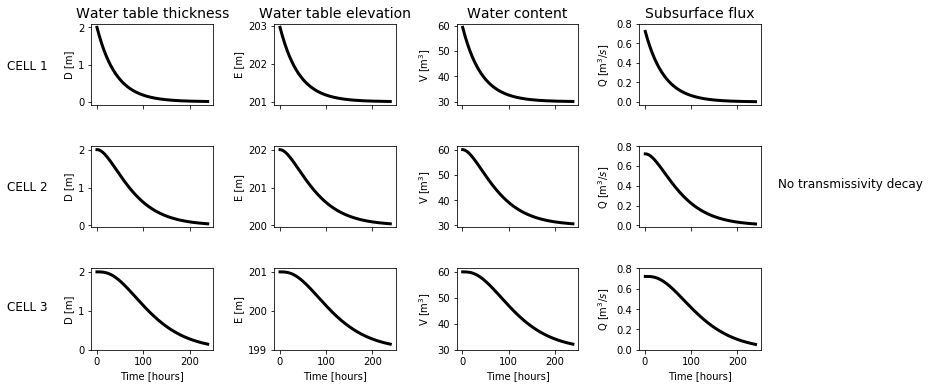

In [140]:
Qdict1 = dict(simul_results[3])
for i in Qdict1:
    Qdict1[i] = np.ndarray.tolist(Qdict1[i])[0]
Sdict1 = dict(simul_results[2])
for i in Sdict1:
    Sdict1[i] = np.ndarray.tolist(Sdict1[i])[0]
Edict1 = dict(simul_results[1])
for i in Edict1:
    Edict1[i] = np.ndarray.tolist(Edict1[i])[0]
ddict1 = dict(simul_results[0])
for i in ddict1:
    ddict1[i] = np.ndarray.tolist(ddict1[i])[0]

d_df = pd.DataFrame.from_dict(ddict1, orient='index')
E_df = pd.DataFrame.from_dict(Edict1, orient='index')
S_df = pd.DataFrame.from_dict(Sdict1, orient='index')
Q_df = pd.DataFrame.from_dict(Qdict1, orient='index')
#d_df.head()


fig, axes = plt.subplots(3, 4, sharex=True, figsize=(12,6))
axes[0,0].set_title('Water table thickness', fontsize=14)
axes[0,1].set_title('Water table elevation', fontsize=14)
axes[0,2].set_title('Water content', fontsize=14)
axes[0,3].set_title('Subsurface flux', fontsize=14)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes[2,0].set_xlabel('Time [hours]', fontsize=10)
axes[2,1].set_xlabel('Time [hours]', fontsize=10)
axes[2,2].set_xlabel('Time [hours]', fontsize=10)
axes[2,3].set_xlabel('Time [hours]', fontsize=10)

cols = d_df.shape[1]
x = d_df.index
for i in range(cols):
    axes[i,0].plot(x, d_df[i], linewidth=3, color="k")
    axes[i,0].set_yticks([0.0, 1.0, 2.0])
    axes[i,0].set_ylabel('D [m]', fontsize=10)
    #axes[i,0].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
    plt.gcf().text(0.0275, 0.775-0.28*i, "CELL "+str(i+1), fontsize=12)
for i in range(cols):
    axes[i,1].plot(x[1:], E_df[i][1:], linewidth=3, color="k")
    axes[i,1].set_yticks([elev[0,i], elev[0,i]-1, elev[0,i]-2])
    #axes[i,1].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
    axes[i,1].set_ylabel('E [m]', fontsize=10)
for i in range(cols):
    axes[i,2].plot(x[1:], S_df[i][1:], linewidth=3, color="k")
    axes[i,2].set_yticks([30,40,50,60])
    axes[i,2].set_ylabel('V [m$^3$]', fontsize=10)
    #axes[i,2].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
for i in range(cols):
    axes[i,3].plot(x[1:], Q_df[i][1:], linewidth=3, color="k")
    axes[i,3].set_yticks([0,0.2,0.4,0.6,0.8])
    axes[i,3].set_ylabel('Q [m$^3/s$]', fontsize=10)
    #axes[i,3].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
axes[2,1].set_yticks([199,200,201])

if decaying_transmissivity == False:
    plt.gcf().text(0.92, 0.5, "No transmissivity decay", fontsize=12)
    fig.show()
    plt.savefig("drainTheAquifer_noDecay_plots.jpg".format(m), dpi=85)
else:
    plt.gcf().text(0.92, 0.5, "m = "+str(m), fontsize=12)
    fig.show()
    plt.savefig("drainTheAquifer_Decay{}_plots.jpg".format(m), dpi=85)
cols

[0.516026882316169, 0.6370201617371267, 0.7580134411580846, 0.8790067205790423, 1.0]


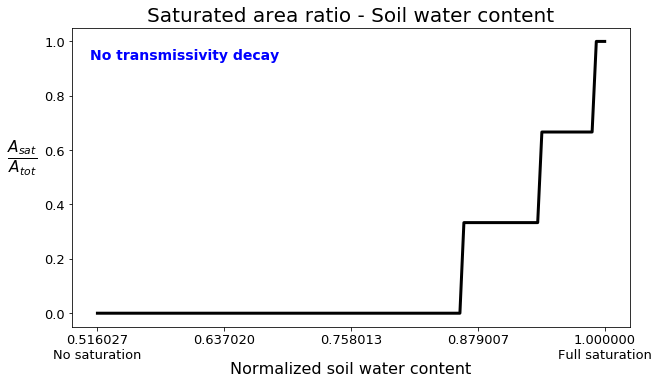

In [144]:
d_df.head()
Vsoilwater_list = []
Area_ratio_list = []
for i in d_df.index.tolist():
    saturated_area = 0
    water_volume = 0
    for j in range(3):
        if d_df.iloc[i][j] >= D-0.1:
            saturated_area += resol*resol
        water_volume += S_df.iloc[i][j]
    Area_ratio = saturated_area / (3*resol*resol)
    Vsoilwater_list.append(water_volume/180)
    Area_ratio_list.append(Area_ratio)

fig,ax = plt.subplots(figsize=(10,5.5))
ax.set_title('Saturated area ratio - Soil water content', fontsize=20)
ax.set_ylabel(r'$\frac{A_{sat}}{A_{tot}}$', fontsize=22, labelpad=22, rotation='horizontal')
ax.set_xlabel("Normalized soil water content", fontsize=16, labelpad=0, rotation='horizontal')
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=13)
spaced_xticks = [min(Vsoilwater_list),
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.25,
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.5,
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.75,
                 max(Vsoilwater_list)]
#spaced_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
print(spaced_xticks)
ax.set_xticks(spaced_xticks)
ax.set_xticklabels(['{:1f}'.format(spaced_xticks[0])+"\nNo saturation",
                    '{:1f}'.format(spaced_xticks[1]),
                    '{:1f}'.format(spaced_xticks[2]),
                    '{:1f}'.format(spaced_xticks[3]),
                    '{:1f}'.format(spaced_xticks[-1])+"\nFull saturation"], 
                   fontsize=13)

ax.plot(Vsoilwater_list, Area_ratio_list, color='k', linewidth=3)

if decaying_transmissivity == False:
    plt.gcf().text(0.15, 0.8, "No transmissivity decay", fontsize=14, color='blue', fontweight="bold")
    fig.show()
    plt.savefig("satAreaRatio_SoilWaterVol_noDecay.jpg".format(m), dpi=85)
else:
    plt.gcf().text(0.15, 0.8, "m = "+str(m), fontsize=14, color='blue', fontweight="bold")
    fig.show()
    plt.savefig("satAreaRatio_SoilWaterVol_Decay{}.jpg".format(m), dpi=85)
   

In [149]:
#ddict
d = 1
Transmissivity = (Ks*D) * np.exp(-1*(1.9-d)/0.05)
Q1 = Transmissivity * resol * slope
Q2 = Ks * d * resol * slope
#print(Q1, Q2)
Q_df.to_csv("simple_dem_Q.csv")
Ks


0.36